In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def first_prep(data_path):
  data=pd.read_csv(data_path)
  data["Time(year-month-day h:m:s)"] = pd.to_datetime(data["Time(year-month-day h:m:s)"])
  data= data.sort_values(by='Time(year-month-day h:m:s)', ascending=True)
  data.set_index('Time(year-month-day h:m:s)', inplace=True)
  data=data.resample('H').mean()
  return data

In [ ]:
solar_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Solar-station-site-1-_Nominal-capacity-50MW_.csv')
wind_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Wind-farm-site-1-_Nominal-capacity-99MW_-_1_.csv')

In [ ]:
Solar_Power=solar_data[['Power (MW)']].copy()
Wind_Power=wind_data[['Power (MW)']].copy()

In [ ]:
#Split the data into train and test for solar data
train_S=Solar_Power[:int(len(Solar_Power)*0.8)]
test_S=Solar_Power[int(len(Solar_Power)*0.8):]
#Split the data into train and test
train_W=Wind_Power[:int(len(Wind_Power)*0.8)]
test_W=Wind_Power[int(len(Wind_Power)*0.8):]

In [ ]:
def evalute_model(model,data,train,test,start,step_in,n_forecast,color_d):
 predictions=model.predict(start=len(train)+step_in+start,end=start+len(train)+step_in+n_forecast,dynamic=False)

 plt.figure(figsize=(10,5))
 plt.plot(data.index[len(train)+start:len(train)+step_in+1+start],data[len(train)+start:len(train)+step_in+1+start],color=color_d)
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+n_forecast+1+start],test[step_in+start:step_in+n_forecast+1+start],label='Valeurs Réels',color='green')
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+n_forecast+1+start],predictions,linestyle='dashed',color='red',label='Prévision par SARIMA')
 plt.xlabel('Temps')
 plt.ylabel('Energie en (MW)')
 plt.legend()
 plt.title('Valeurs prévisionnelles vs Valeurs réelles')
 mae=mean_absolute_error(test[:n_forecast+1],predictions)
 mse=mean_squared_error(test[:n_forecast+1],predictions)
 rmse = np.sqrt(mse)
 mape = mean_absolute_percentage_error(test[:n_forecast+1],predictions)
 print('mae=',mae)
 print('mse=',mse)
 print('rmse=',rmse)
 print('mape=',mape)
 return predictions

In [ ]:
import pickle
def save_model(model,file_name):
 # Save the trained ARMA model using pickle
 with open(file_name, 'wb') as file:
    pickle.dump(model, file)

import pickle
def load_model(file_name):
  with open(file_name, 'rb') as file:
    loaded_model = pickle.load(file)
  return loaded_model

In [ ]:
#build model SARIMA for solar power
model_SARIMA_S = sm.tsa.statespace.SARIMAX(train_S, order=(12, 1, 1),seasonal_order=(1, 1, 1, 24))
model_SARIMA_S=model_SARIMA_S.fit()

In [ ]:
save_model(model_SARIMA_S,'/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMA_S(1).pkl')

In [ ]:
model_SARIMA_S=load_model('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMA_S(1).pkl')

mae= 2.8371585110742523
mse= 24.568388777973198
rmse= 4.956650963904277
mape= 422393150559422.1


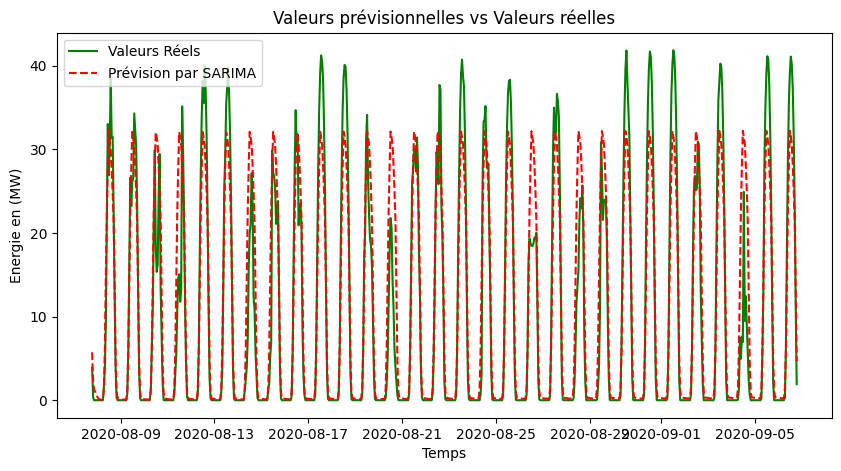

In [ ]:
prediciton_SARIMA_s=evalute_model(model_SARIMA_S,Solar_Power,train_S,test_S,0,0,720,'orange')

In [ ]:
#build model SARIMA for wind power
model_SARIMA_W = sm.tsa.statespace.SARIMAX(train_W, order=(12, 1, 1),seasonal_order=(1, 1, 1, 24))
model_SARIMA_W=model_SARIMA_W.fit()
#model_SARIMA_W.summary()

In [ ]:
save_model(model_SARIMA_W,'/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMA_W(1).pkl')

In [ ]:
model_SARIMA_W=load_model('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMA_W(1).pkl')

mae= 25.62500177976491
mse= 810.1301305066942
rmse= 28.462785009669982
mape= 278679188559467.47


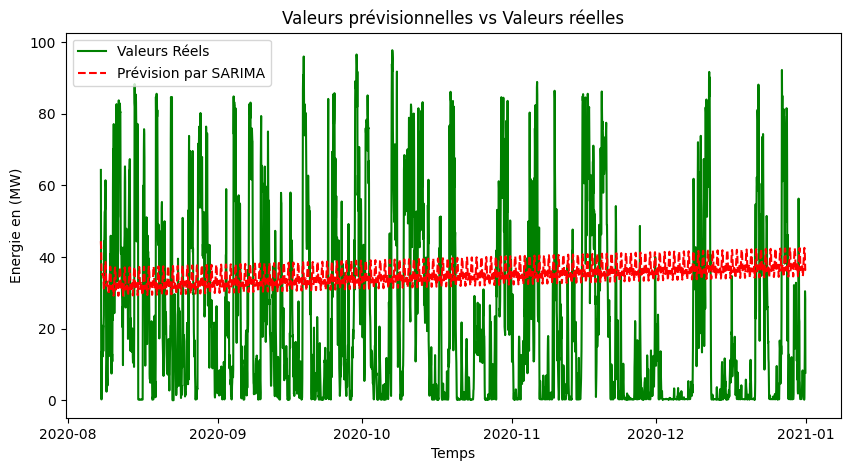

In [ ]:
prediciton_SARIMA_w=evalute_model(model_SARIMA_W,Wind_Power,train_W,test_W,0,0,len(test_W)-1,None)